## Import Relevant Libraries

In [86]:
#Import relevant Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import tree


## Read Datasets

In [87]:
#set datafram display 
pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 2)

In [88]:
#import datasets
df_listing=pd.read_csv("listings.csv")
df_calendar=pd.read_csv("calendar.csv")

#make copies of each dataframe
df_listing_ori=df_listing.copy()
df_calendar_ori=df_calendar.copy()

## Calender Dataset - Data Preperation

In [89]:
df_calendar.head(10)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN
5,241032,2016-01-09,f,NaN
6,241032,2016-01-10,f,NaN
7,241032,2016-01-11,f,NaN
8,241032,2016-01-12,f,NaN
9,241032,2016-01-13,t,$85.00


From the above we can see that there are plenty of gaps in the "price" field. It appears that the pricing data is only recorded when the listing is available.

Its unlikely that the pricing for these dates where the pricing is missing changes significantly just because the property is occupied.

 - We could potentially explore the possibility of forward filling these Nan values grouped by the listing_id. Initially we will not forward fill and see if we can build a somewhat accurate model from the start

In [90]:
#Pricing column has Nan values
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


The pricing field contains Nan values. As this is the target field that we're trying to predict, lets drop the rows where the target isn't present

In [91]:
#drop rows where the price is Nan
df_calendar=df_calendar.dropna(subset=["price"], axis=0)

#Check Non Nan count is the same
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 934542 entries, 0 to 1393213
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   listing_id  934542 non-null  int64 
 1   date        934542 non-null  object
 2   available   934542 non-null  object
 3   price       934542 non-null  object
dtypes: int64(1), object(3)
memory usage: 35.6+ MB


This data frame contains nearly 1 million observations. Let's check if we can aggregate by month.

If we convert the "price" field to a float and then run some summary statistics on it then we should be able to see how much the price varies for each listing_id

In [92]:
df_calendar['month'] = df_calendar.apply(lambda row: int(row['date'].split('-')[1]),axis=1)
df_calendar.head()

,listing_id,date,available,price,month
0,241032,2016-01-04,t,$85.00,1
1,241032,2016-01-05,t,$85.00,1
9,241032,2016-01-13,t,$85.00,1
10,241032,2016-01-14,t,$85.00,1
14,241032,2016-01-18,t,$85.00,1


In [93]:
def strtofloat(df,dollar_cols):
    '''
    Input:dataframe, list of columns you'd like to convert from $strings or %strings to floats
    Output: returns the input data frame with the converted value in place
    '''
    for col in dollar_cols:
            df[col]=df[col].str.replace("[$, ,%]", "")  
            df[col]=df[col].astype("float")

dollar_cols=["price"]            
strtofloat(df_calendar,dollar_cols)
df_calendar[dollar_cols].head()

,price
0,85.000
1,85.000
9,85.000
10,85.000
14,85.000


In [94]:
df = df_calendar.groupby(['listing_id']).describe()

In [95]:
df1=df["price"].head(20)
df1["cov"]=df1["std"]/df1["mean"]
df1.nlargest(5,"cov")

,count,mean,std,min,25%,50%,75%,max,cov
listing_id,,,,,,,,,
19619,137.000,198.796,53.713,130.000,170.000,187.000,254.000,311.000,0.270
19611,151.000,154.828,38.555,108.000,127.500,141.000,198.000,257.000,0.249
13068,344.000,414.985,72.760,252.000,360.000,360.000,499.000,574.000,0.175
9419,365.000,85.616,11.313,70.000,70.000,90.000,90.000,100.000,0.132
5682,309.000,53.945,5.025,42.000,48.000,53.000,60.000,60.000,0.093


When we create a ratio of the STD to the mean to create the coefficient of variance "cov" and the sort by the 5th largest we see that the values do not change by much over the months.

Let's drop the date column and drop the duplicate rows.

In [96]:
#drop date attribute
df_calendar.drop(["date"],inplace=True,axis=1),

df_calendar.head()

,listing_id,available,price,month
0,241032,t,85.000,1
1,241032,t,85.000,1
9,241032,t,85.000,1
10,241032,t,85.000,1
14,241032,t,85.000,1


In [97]:
df_calendar.shape

(934542, 4)

In [98]:
#remove duplicate rows
df_calendar=df_calendar.drop_duplicates()

In [99]:
df_calendar.shape

(73025, 4)

We can see that we have significantly reduced the size of this dataframe

In [100]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73025 entries, 0 to 1393205
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   listing_id  73025 non-null  int64  
 1   available   73025 non-null  object 
 2   price       73025 non-null  float64
 3   month       73025 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 2.8+ MB


In [101]:
#columns full of unique values
def unique_columns(df):
    '''
    Input:dataframe
    Output: print columns that are full of unique (non repeating) values
    '''

    for col in df.columns:
        a=len(df[col].unique())/df.shape[0]
        if a==1:
            print(col+" "+'%.2f' %a)
    print("end")
unique_columns(df_calendar)

end


In [102]:
#find average price per month
average_price_by_month = df_calendar.groupby(['month'])['price'].mean().reset_index()

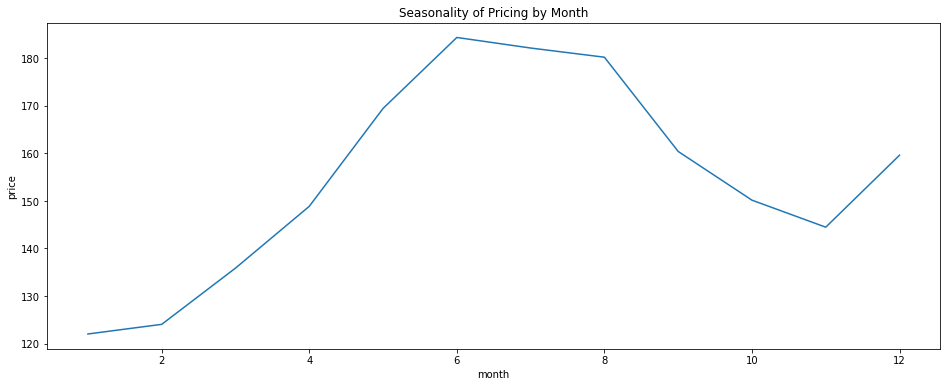

In [103]:
plt.figure(figsize=(16, 6))
plt.title('Seasonality of Pricing by Month')
sns.lineplot(data=average_price_by_month,
             x="month",
             y="price",
             err_style="bars")
plt.savefig('Seasonality of Pricing by Month.png')

## Listing Dataset - Data Preperation

In [104]:
df_listing.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.000,3.000,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636,-122.371,t,Apartment,Entire home/apt,4,1.000,1.000,1.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",nan,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.000,10.000,10.000,10.000,10.000,9.000,10.000,f,nan,WASHINGTON,f,moderate,f,f,2,4.070
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.000,6.000,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639,-122.366,t,Apartment,Entire home/apt,4,1.000,1.000,1.000,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",nan,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.000,10.000,10.000,10.000,10.000,10.000,10.000,f,nan,WASHINGTON,f,strict,t,t,6,1.480


In [105]:
#rename the 'id' column in listing.csv to 'listing_id'
df_listing = df_listing.rename(index=str, columns = {'id':'listing_id'})

Check which columns are unique

In [106]:
unique_columns(df_listing)

listing_id 1.00
listing_url 1.00
picture_url 1.00
latitude 1.00
longitude 1.00
end


In [107]:
#list of fields that I want to drop
columns_to_drop=[]
unique_cols=["listing_url",
             "picture_url",
             "latitude",
             "longitude"]
columns_to_drop=columns_to_drop+unique_cols
columns_to_drop

['listing_url', 'picture_url', 'latitude', 'longitude']

Let's check which columns only have a few unique values and assess their value

In [108]:
def cols_with_few(df,threshold):
    '''
    Input: Dataframe, threshold of unique values
    Output: Prints of fields and the unique values they contain
    Global variables: few, a list of fields
    '''

    for col in df.columns:
        a=df[col].unique().shape[0]
        if a<threshold:
            a=df_listing[col].value_counts()
            print("")
            print("##############")
            print(col)
            print(a)


In [109]:
cols_with_few(df_listing,5)


##############
scrape_id
20160104002432    3818
Name: scrape_id, dtype: int64

##############
last_scraped
2016-01-04    3818
Name: last_scraped, dtype: int64

##############
experiences_offered
none    3818
Name: experiences_offered, dtype: int64

##############
host_acceptance_rate
100%    3044
0%         1
Name: host_acceptance_rate, dtype: int64

##############
host_is_superhost
f    3038
t     778
Name: host_is_superhost, dtype: int64

##############
host_has_profile_pic
t    3809
f       7
Name: host_has_profile_pic, dtype: int64

##############
host_identity_verified
t    2997
f     819
Name: host_identity_verified, dtype: int64

##############
state
WA    3817
wa       1
Name: state, dtype: int64

##############
market
Seattle    3818
Name: market, dtype: int64

##############
country_code
US    3818
Name: country_code, dtype: int64

##############
country
United States    3818
Name: country, dtype: int64

##############
is_location_exact
t    3412
f     406
Name: is_location_

In [110]:
#columns to remove from the dataframe
few_columns=["scrape_id",
             "last_scraped",
             "experiences_offered",
             "host_acceptance_rate",
             "host_has_profile_pic",
             "state",
             "market",
             "country_code",
             "country",
             "has_availability",
            "calendar_last_scraped",
             "requires_license",
             "license",
             "jurisdiction_names",
             "instant_bookable"]
columns_to_drop=columns_to_drop+few_columns

#remove duplicate values from the list
columns_to_drop = [i for j, i in enumerate(columns_to_drop) if i not in columns_to_drop[:j]] 
columns_to_drop

['listing_url',
 'picture_url',
 'latitude',
 'longitude',
 'scrape_id',
 'last_scraped',
 'experiences_offered',
 'host_acceptance_rate',
 'host_has_profile_pic',
 'state',
 'market',
 'country_code',
 'country',
 'has_availability',
 'calendar_last_scraped',
 'requires_license',
 'license',
 'jurisdiction_names',
 'instant_bookable']

In [111]:
df_listing_drop1=df_listing.drop(columns_to_drop,axis=1)
df_listing_drop1.head()

,listing_id,name,summary,space,description,neighborhood_overview,notes,transit,thumbnail_url,medium_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,zipcode,smart_location,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,NaN,NaN,NaN,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.000,3.000,"['email', 'phone', 'reviews', 'kba']",t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,98119,"Seattle, WA",t,Apartment,Entire home/apt,4,1.000,1.000,1.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",nan,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,14,41,71,346,207,2011-11-01,2016-01-02,95.000,10.000,10.000,10.000,10.000,9.000,10.000,moderate,f,f,2,4.070
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.000,6.000,"['email', 'phone', 'facebook', 'linkedin', 're...",t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,98119,"Seattle, WA",t,Apartment,Entire home/apt,4,1.000,1.000,1.000,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",nan,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,13,13,16,291,43,2013-08-19,2015-12-29,96.000,10.000,10.000,10.000,10.000,10.000,10.000,strict,t,t,6,1.480
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,NaN,NaN,NaN,16708587,https://www.airbnb.com/users/show/16708587,Jill,2014-06-12,"Seattle, Washington, United States",i love living in Seattle. i grew up in the mi...,within a few hours,67%,f,https://a1.muscache.com/ac/users/16708587/prof...,https://a1.muscache.com/ac/users/16708587/prof...,Queen Anne,2.000,2.000,"['email', 'phone', 'google', 'reviews', 'jumio']",t,

In [112]:
cols_with_few(df_listing_drop1,10)


##############
host_response_time
within an hour        1692
within a few hours     968
within a day           597
a few days or more      38
Name: host_response_time, dtype: int64

##############
host_is_superhost
f    3038
t     778
Name: host_is_superhost, dtype: int64

##############
host_identity_verified
t    2997
f     819
Name: host_identity_verified, dtype: int64

##############
city
Seattle                  3810
West Seattle                2
Seattle                     2
Phinney Ridge Seattle       1
西雅图                         1
seattle                     1
Ballard, Seattle            1
Name: city, dtype: int64

##############
smart_location
Seattle, WA                  3810
West Seattle, WA                2
Seattle , WA                    2
seattle, wa                     1
Phinney Ridge Seattle, WA       1
西雅图, WA                         1
Ballard, Seattle, WA            1
Name: smart_location, dtype: int64

##############
is_location_exact
t    3412
f     406
Name: is_l

In [113]:
few_columns=["city",
             "smart_location"]
columns_to_drop=columns_to_drop+few_columns
columns_to_drop = [i for j, i in enumerate(columns_to_drop) if i not in columns_to_drop[:j]] 
df_listing_drop2=df_listing.drop(columns_to_drop,axis=1,errors="ignore")
df_listing_drop2.head()

,listing_id,name,summary,space,description,neighborhood_overview,notes,transit,thumbnail_url,medium_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,zipcode,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,NaN,NaN,NaN,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.000,3.000,"['email', 'phone', 'reviews', 'kba']",t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,98119,t,Apartment,Entire home/apt,4,1.000,1.000,1.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",nan,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,14,41,71,346,207,2011-11-01,2016-01-02,95.000,10.000,10.000,10.000,10.000,9.000,10.000,moderate,f,f,2,4.070
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.000,6.000,"['email', 'phone', 'facebook', 'linkedin', 're...",t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,98119,t,Apartment,Entire home/apt,4,1.000,1.000,1.000,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",nan,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,13,13,16,291,43,2013-08-19,2015-12-29,96.000,10.000,10.000,10.000,10.000,10.000,10.000,strict,t,t,6,1.480
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,NaN,NaN,NaN,16708587,https://www.airbnb.com/users/show/16708587,Jill,2014-06-12,"Seattle, Washington, United States",i love living in Seattle. i grew up in the mi...,within a few hours,67%,f,https://a1.muscache.com/ac/users/16708587/prof...,https://a1.muscache.com/ac/users/16708587/prof...,Queen Anne,2.000,2.000,"['email', 'phone', 'google', 'reviews', 'jumio']",t,"West Lee Street, Seattle, WA 98119, United States",Queen Anne,W

In [114]:
df_listing_drop2["host_verifications"].value_counts()

['email', 'phone', 'facebook', 'reviews', 'kba']                                  595
['email', 'phone', 'reviews', 'kba']                                              436
['email', 'phone', 'reviews']                                                     329
['email', 'phone', 'facebook', 'reviews', 'jumio']                                322
['email', 'phone', 'reviews', 'jumio']                                            194
                                                                                 ... 
['google', 'jumio']                                                                 1
['phone', 'facebook', 'reviews', 'kba']                                             1
['email', 'phone', 'google', 'linkedin', 'reviews', 'manual_offline', 'jumio']      1
['email', 'facebook', 'reviews', 'kba']                                             1
['email', 'phone', 'google', 'linkedin', 'reviews']                                 1
Name: host_verifications, Length: 116, dtype: int64

In [115]:
text_cols=["name",
           "summary",
           "space",
           "description",
           "neighborhood_overview",
           "notes",
           "transit",
           "thumbnail_url",
           "medium_url",
           "xl_picture_url",
           "host_id",
           "host_url",
           "host_name",
           "host_since",
           "host_location",
           "host_about",
           "host_thumbnail_url",
           "host_picture_url",
           "host_verifications",
           "calendar_updated",
           "street"]
columns_to_drop=columns_to_drop+text_cols
columns_to_drop = [i for j, i in enumerate(columns_to_drop) if i not in columns_to_drop[:j]] 
df_listing_drop3=df_listing.drop(columns_to_drop,axis=1,errors="ignore")
df_listing_drop3.head()

,listing_id,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,zipcode,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,within a few hours,96%,f,Queen Anne,3.000,3.000,t,Queen Anne,West Queen Anne,Queen Anne,98119,t,Apartment,Entire home/apt,4,1.000,1.000,1.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",nan,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,14,41,71,346,207,2011-11-01,2016-01-02,95.000,10.000,10.000,10.000,10.000,9.000,10.000,moderate,f,f,2,4.070
1,953595,within an hour,98%,t,Queen Anne,6.000,6.000,t,Queen Anne,West Queen Anne,Queen Anne,98119,t,Apartment,Entire home/apt,4,1.000,1.000,1.000,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",nan,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,13,13,16,291,43,2013-08-19,2015-12-29,96.000,10.000,10.000,10.000,10.000,10.000,10.000,strict,t,t,6,1.480
2,3308979,within a few hours,67%,f,Queen Anne,2.000,2.000,t,Queen Anne,West Queen Anne,Queen Anne,98119,t,House,Entire home/apt,11,4.500,5.000,7.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",nan,$975.00,NaN,NaN,"$1,000.00",$300.00,10,$25.00,4,30,1,6,17,220,20,2014-07-30,2015-09-03,97.000,10.000,10.000,10.000,10.000,10.000,10.000,strict,f,f,2,1.150
3,7421966,NaN,NaN,f,Queen Anne,1.000,1.000,t,Queen Anne,West Queen Anne,Queen Anne,98119,t,Apartment,Entire home/apt,3,1.000,0.000,2.000,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",nan,$100.00,$650.00,"$2,300.00",NaN,NaN,1,$0.00,1,1125,0,0,0,143,0,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,flexible,f,f,1,nan
4,278830,within an hour,100%,f,Queen Anne,2.000,2.000,t,Queen Anne,West Queen Anne,Queen Anne,98119,t,House,Entire home/apt,6,2.000,3.000,3.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",nan,$450.00,NaN,NaN,$700.00,$125.00,6,$15.00,1,1125,30,60,90,365,38,2012-07-10,2015-10-24,92.000,9.000,9.000,10.000,10.000,9.000,9.000,strict,f,f,1,0.890


Further inspection of the dataframe

In [116]:
redundant_cols=["host_neighbourhood",
                "host_listings_count",
                "host_total_listings_count",
                "neighbourhood",
                "neighbourhood_cleansed",
                "zipcode",
                "is_location_exact",
                "guests_included",
                "price",
                "minimum_nights",
                "maximum_nights",
                "availability_30",
                "availability_60",
                "availability_90",
                "first_review",
                "last_review",
                "calculated_host_listings_count",
                "reviews_per_month",
                "host_identity_verified"]

binary_cols=["weekly_price",
             "monthly_price",
             "security_deposit",
             "extra_people",
             "cleaning_fee"]

multicolinearity_cols=["review_scores_rating",
                        "review_scores_accuracy",
                        "review_scores_cleanliness",
                        "review_scores_checkin",
                        "review_scores_communication",
                        "review_scores_location",
                        "review_scores_value"]

In [117]:
columns_to_drop=columns_to_drop+redundant_cols
columns_to_drop = [i for j, i in enumerate(columns_to_drop) if i not in columns_to_drop[:j]] 
df_listing_drop4=df_listing.drop(columns_to_drop,axis=1,errors="ignore")
df_listing_drop4.head()

,listing_id,host_response_time,host_response_rate,host_is_superhost,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,241032,within a few hours,96%,f,Queen Anne,Apartment,Entire home/apt,4,1.000,1.000,1.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",nan,NaN,NaN,NaN,NaN,$5.00,346,207,95.000,10.000,10.000,10.000,10.000,9.000,10.000,moderate,f,f
1,953595,within an hour,98%,t,Queen Anne,Apartment,Entire home/apt,4,1.000,1.000,1.000,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",nan,"$1,000.00","$3,000.00",$100.00,$40.00,$0.00,291,43,96.000,10.000,10.000,10.000,10.000,10.000,10.000,strict,t,t
2,3308979,within a few hours,67%,f,Queen Anne,House,Entire home/apt,11,4.500,5.000,7.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",nan,NaN,NaN,"$1,000.00",$300.00,$25.00,220,20,97.000,10.000,10.000,10.000,10.000,10.000,10.000,strict,f,f
3,7421966,NaN,NaN,f,Queen Anne,Apartment,Entire home/apt,3,1.000,0.000,2.000,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",nan,$650.00,"$2,300.00",NaN,NaN,$0.00,143,0,nan,nan,nan,nan,nan,nan,nan,flexible,f,f
4,278830,within an hour,100%,f,Queen Anne,House,Entire home/apt,6,2.000,3.000,3.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",nan,NaN,NaN,$700.00,$125.00,$15.00,365,38,92.000,9.000,9.000,10.000,10.000,9.000,9.000,strict,f,f


There are some values here that dont nessiarially add value but their presence can be coverted to a binary 1-0 for the sake of modelling

In [118]:
df_listing_drop4[binary_cols].head()

,weekly_price,monthly_price,security_deposit,extra_people,cleaning_fee
0,NaN,NaN,NaN,$5.00,NaN
1,"$1,000.00","$3,000.00",$100.00,$0.00,$40.00
2,NaN,NaN,"$1,000.00",$25.00,$300.00
3,$650.00,"$2,300.00",NaN,$0.00,NaN
4,NaN,NaN,$700.00,$15.00,$125.00


In [119]:
df_listing_bin=df_listing_drop4.copy()
for col in binary_cols:
    df_listing_bin[col]=df_listing_bin[col].apply(lambda x: 0 if str(x).find("$") else 1)

In [120]:
df_listing_bin.head()

,listing_id,host_response_time,host_response_rate,host_is_superhost,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,241032,within a few hours,96%,f,Queen Anne,Apartment,Entire home/apt,4,1.000,1.000,1.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",nan,0,0,0,0,1,346,207,95.000,10.000,10.000,10.000,10.000,9.000,10.000,moderate,f,f
1,953595,within an hour,98%,t,Queen Anne,Apartment,Entire home/apt,4,1.000,1.000,1.000,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",nan,1,1,1,1,1,291,43,96.000,10.000,10.000,10.000,10.000,10.000,10.000,strict,t,t
2,3308979,within a few hours,67%,f,Queen Anne,House,Entire home/apt,11,4.500,5.000,7.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",nan,0,0,1,1,1,220,20,97.000,10.000,10.000,10.000,10.000,10.000,10.000,strict,f,f
3,7421966,NaN,NaN,f,Queen Anne,Apartment,Entire home/apt,3,1.000,0.000,2.000,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",nan,1,1,0,0,1,143,0,nan,nan,nan,nan,nan,nan,nan,flexible,f,f
4,278830,within an hour,100%,f,Queen Anne,House,Entire home/apt,6,2.000,3.000,3.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",nan,0,0,1,1,1,365,38,92.000,9.000,9.000,10.000,10.000,9.000,9.000,strict,f,f


In [121]:
#lets convert the yearly availability to a percentage
df_listing_bin["availability_365"]=df_listing_bin["availability_365"]/365

In [122]:
df_listing_bin.head()

,listing_id,host_response_time,host_response_rate,host_is_superhost,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,241032,within a few hours,96%,f,Queen Anne,Apartment,Entire home/apt,4,1.000,1.000,1.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",nan,0,0,0,0,1,0.948,207,95.000,10.000,10.000,10.000,10.000,9.000,10.000,moderate,f,f
1,953595,within an hour,98%,t,Queen Anne,Apartment,Entire home/apt,4,1.000,1.000,1.000,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",nan,1,1,1,1,1,0.797,43,96.000,10.000,10.000,10.000,10.000,10.000,10.000,strict,t,t
2,3308979,within a few hours,67%,f,Queen Anne,House,Entire home/apt,11,4.500,5.000,7.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",nan,0,0,1,1,1,0.603,20,97.000,10.000,10.000,10.000,10.000,10.000,10.000,strict,f,f
3,7421966,NaN,NaN,f,Queen Anne,Apartment,Entire home/apt,3,1.000,0.000,2.000,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",nan,1,1,0,0,1,0.392,0,nan,nan,nan,nan,nan,nan,nan,flexible,f,f
4,278830,within an hour,100%,f,Queen Anne,House,Entire home/apt,6,2.000,3.000,3.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",nan,0,0,1,1,1,1.000,38,92.000,9.000,9.000,10.000,10.000,9.000,9.000,strict,f,f


let's check for Multicollinearity or internal correlations

In [123]:
# generating pairwise internal correlations
# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

def get_redundant_pairs(df):
    '''
    Input: Dataframe
    Output: Get diagonal and lower triangular pairs of correlation matrix
    '''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    '''
    Input: Dataframe and the number of correlated pairs
    Output: Dataframe of the pairs and their correlation
    '''
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


In [124]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_listing_num = df_listing_bin.select_dtypes(include=numerics)
print(get_top_abs_correlations(df_listing_num, 10))

accommodates            beds                          0.861
                        bedrooms                      0.771
bedrooms                beds                          0.753
review_scores_rating    review_scores_value           0.697
review_scores_checkin   review_scores_communication   0.696
weekly_price            monthly_price                 0.663
review_scores_rating    review_scores_cleanliness     0.643
                        review_scores_accuracy        0.621
bathrooms               bedrooms                      0.611
review_scores_accuracy  review_scores_value           0.563
dtype: float64


Here we can see many pairs that have some correlation to each other. Only one pair has a correlation above 0.8: accommodates/beds. lets drop "beds" as "accommodates" seems to be a more sussinct measure of how many people would b

In [125]:
df_listing_bin=df_listing_bin.drop("beds",axis=1)

In [126]:
df_listing_bin.head()

,listing_id,host_response_time,host_response_rate,host_is_superhost,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,bed_type,amenities,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,241032,within a few hours,96%,f,Queen Anne,Apartment,Entire home/apt,4,1.000,1.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",nan,0,0,0,0,1,0.948,207,95.000,10.000,10.000,10.000,10.000,9.000,10.000,moderate,f,f
1,953595,within an hour,98%,t,Queen Anne,Apartment,Entire home/apt,4,1.000,1.000,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",nan,1,1,1,1,1,0.797,43,96.000,10.000,10.000,10.000,10.000,10.000,10.000,strict,t,t
2,3308979,within a few hours,67%,f,Queen Anne,House,Entire home/apt,11,4.500,5.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",nan,0,0,1,1,1,0.603,20,97.000,10.000,10.000,10.000,10.000,10.000,10.000,strict,f,f
3,7421966,NaN,NaN,f,Queen Anne,Apartment,Entire home/apt,3,1.000,0.000,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",nan,1,1,0,0,1,0.392,0,nan,nan,nan,nan,nan,nan,nan,flexible,f,f
4,278830,within an hour,100%,f,Queen Anne,House,Entire home/apt,6,2.000,3.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",nan,0,0,1,1,1,1.000,38,92.000,9.000,9.000,10.000,10.000,9.000,9.000,strict,f,f


Lets convert the percentage string to a float

In [127]:
strtofloat(df_listing_bin,["host_response_rate"])
df_listing_bin.head()

,listing_id,host_response_time,host_response_rate,host_is_superhost,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,bed_type,amenities,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,241032,within a few hours,96.000,f,Queen Anne,Apartment,Entire home/apt,4,1.000,1.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",nan,0,0,0,0,1,0.948,207,95.000,10.000,10.000,10.000,10.000,9.000,10.000,moderate,f,f
1,953595,within an hour,98.000,t,Queen Anne,Apartment,Entire home/apt,4,1.000,1.000,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",nan,1,1,1,1,1,0.797,43,96.000,10.000,10.000,10.000,10.000,10.000,10.000,strict,t,t
2,3308979,within a few hours,67.000,f,Queen Anne,House,Entire home/apt,11,4.500,5.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",nan,0,0,1,1,1,0.603,20,97.000,10.000,10.000,10.000,10.000,10.000,10.000,strict,f,f
3,7421966,NaN,nan,f,Queen Anne,Apartment,Entire home/apt,3,1.000,0.000,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",nan,1,1,0,0,1,0.392,0,nan,nan,nan,nan,nan,nan,nan,flexible,f,f
4,278830,within an hour,100.000,f,Queen Anne,House,Entire home/apt,6,2.000,3.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",nan,0,0,1,1,1,1.000,38,92.000,9.000,9.000,10.000,10.000,9.000,9.000,strict,f,f


## Merge Cleaned Calendar and Listing Data Sets

In [128]:
#Merge calendar and listing datasets on the listing_id key
df = pd.merge(df_listing_bin, df_calendar, on='listing_id')
df.head()

,listing_id,host_response_time,host_response_rate,host_is_superhost,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,bed_type,amenities,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,available,price,month
0,241032,within a few hours,96.000,f,Queen Anne,Apartment,Entire home/apt,4,1.000,1.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",nan,0,0,0,0,1,0.948,207,95.000,10.000,10.000,10.000,10.000,9.000,10.000,moderate,f,f,t,85.000,1
1,241032,within a few hours,96.000,f,Queen Anne,Apartment,Entire home/apt,4,1.000,1.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",nan,0,0,0,0,1,0.948,207,95.000,10.000,10.000,10.000,10.000,9.000,10.000,moderate,f,f,t,85.000,2
2,241032,within a few hours,96.000,f,Queen Anne,Apartment,Entire home/apt,4,1.000,1.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",nan,0,0,0,0,1,0.948,207,95.000,10.000,10.000,10.000,10.000,9.000,10.000,moderate,f,f,t,85.000,3
3,241032,within a few hours,96.000,f,Queen Anne,Apartment,Entire home/apt,4,1.000,1.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",nan,0,0,0,0,1,0.948,207,95.000,10.000,10.000,10.000,10.000,9.000,10.000,moderate,f,f,t,85.000,4
4,241032,within a few hours,96.000,f,Queen Anne,Apartment,Entire home/apt,4,1.000,1.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",nan,0,0,0,0,1,0.948,207,95.000,10.000,10.000,10.000,10.000,9.000,10.000,moderate,f,f,t,85.000,5


In [129]:
#drop a useles column
df.drop("available",inplace=True,axis=1)

df.head(2)

,listing_id,host_response_time,host_response_rate,host_is_superhost,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,bed_type,amenities,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,price,month
0,241032,within a few hours,96.000,f,Queen Anne,Apartment,Entire home/apt,4,1.000,1.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",nan,0,0,0,0,1,0.948,207,95.000,10.000,10.000,10.000,10.000,9.000,10.000,moderate,f,f,85.000,1
1,241032,within a few hours,96.000,f,Queen Anne,Apartment,Entire home/apt,4,1.000,1.000,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",nan,0,0,0,0,1,0.948,207,95.000,10.000,10.000,10.000,10.000,9.000,10.000,moderate,f,f,85.000,2


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73025 entries, 0 to 73024
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   listing_id                        73025 non-null  int64  
 1   host_response_time                68274 non-null  object 
 2   host_response_rate                68274 non-null  float64
 3   host_is_superhost                 73017 non-null  object 
 4   neighbourhood_group_cleansed      73025 non-null  object 
 5   property_type                     73013 non-null  object 
 6   room_type                         73025 non-null  object 
 7   accommodates                      73025 non-null  int64  
 8   bathrooms                         72775 non-null  float64
 9   bedrooms                          72908 non-null  float64
 10  bed_type                          73025 non-null  object 
 11  amenities                         73025 non-null  object 
 12  squa

In the above we can see that in quite a few columns there are many nan values. Let's inspect this

In [131]:
def display_nans(df,cut_off,display=True):
    '''
    INPUT: Dataframe, cut_off decimal to remove columns with less than this percentage of Nan
    OUTPUT: Graph with % of nan values in each column
    '''
    
    global df_nan
    df_nan = pd.DataFrame(df.isna().sum() / df.shape[0]).reset_index()
    df_nan.rename(columns={'index':'column',0:'na_per'},inplace=True)
    
    # sort df by Count column
    df_nan = df_nan.sort_values(['na_per'],ascending=False).reset_index(drop=True)
    
    # Remove fll columns
    df_nan=df_nan[df_nan["na_per"]>cut_off]
    
    if display ==True:
        base_color = sns.color_palette()[0]
        plt.figure(figsize=(16,16))
        plt.title('Percentage of missing values by column')
        sns.barplot(data=df_nan,y='column', x='na_per', color=base_color)
        plt.savefig('Percentage of Nan.png')
    return df_nan

,column,na_per
0,square_feet,0.972
1,review_scores_checkin,0.111
2,review_scores_accuracy,0.110
3,review_scores_value,0.110
4,review_scores_location,0.110
5,review_scores_cleanliness,0.110
6,review_scores_communication,0.110
7,review_scores_rating,0.109


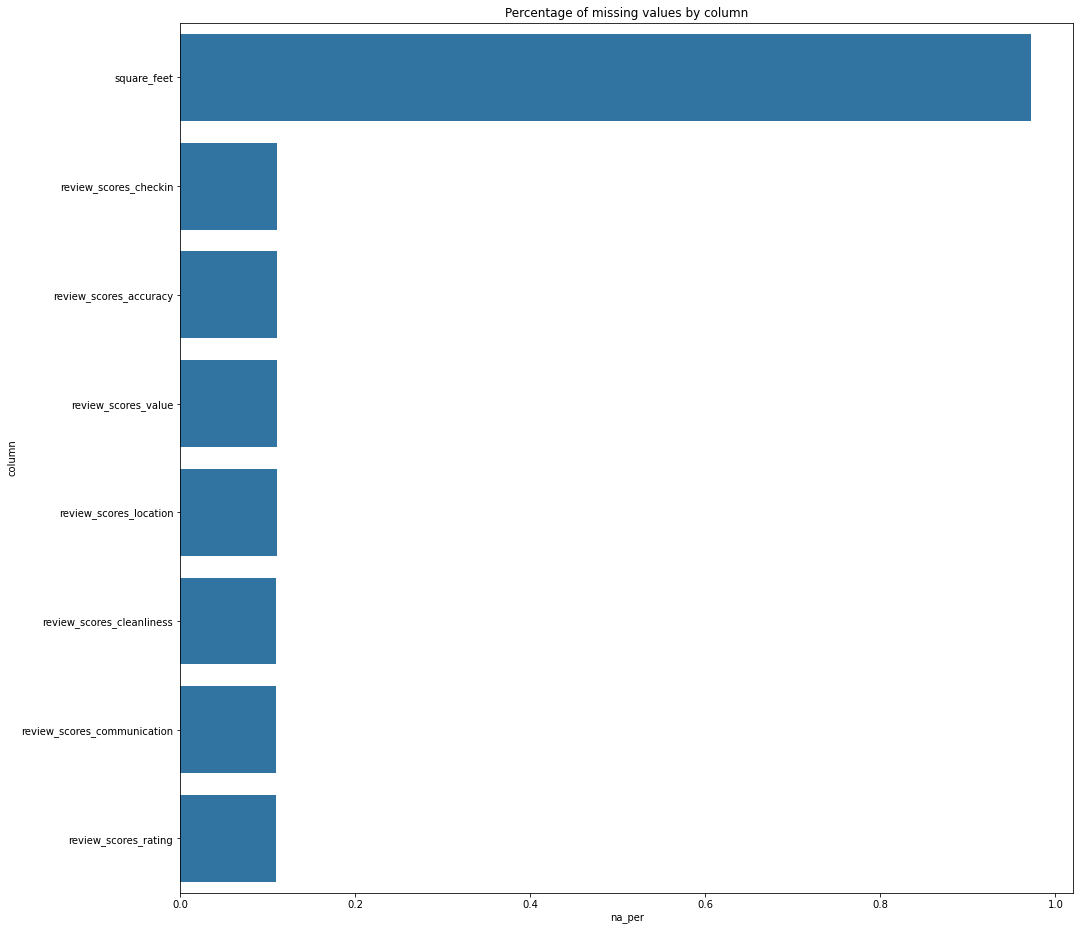

In [132]:
display_nans(df,0.1)

We can see that the square_feet field is almost completely empty, so we do not have a reasonable recourse. Let's drop this field

In [133]:
df.drop("square_feet",inplace=True,axis=1)

Let's plot the remaining Nan columns and check what the distribution of values are like.

,column,na_per
0,review_scores_checkin,0.111
1,review_scores_accuracy,0.110
2,review_scores_value,0.110
3,review_scores_location,0.110
4,review_scores_cleanliness,0.110
5,review_scores_communication,0.110
6,review_scores_rating,0.109
7,host_response_rate,0.065
8,host_response_time,0.065
9,bathrooms,0.003


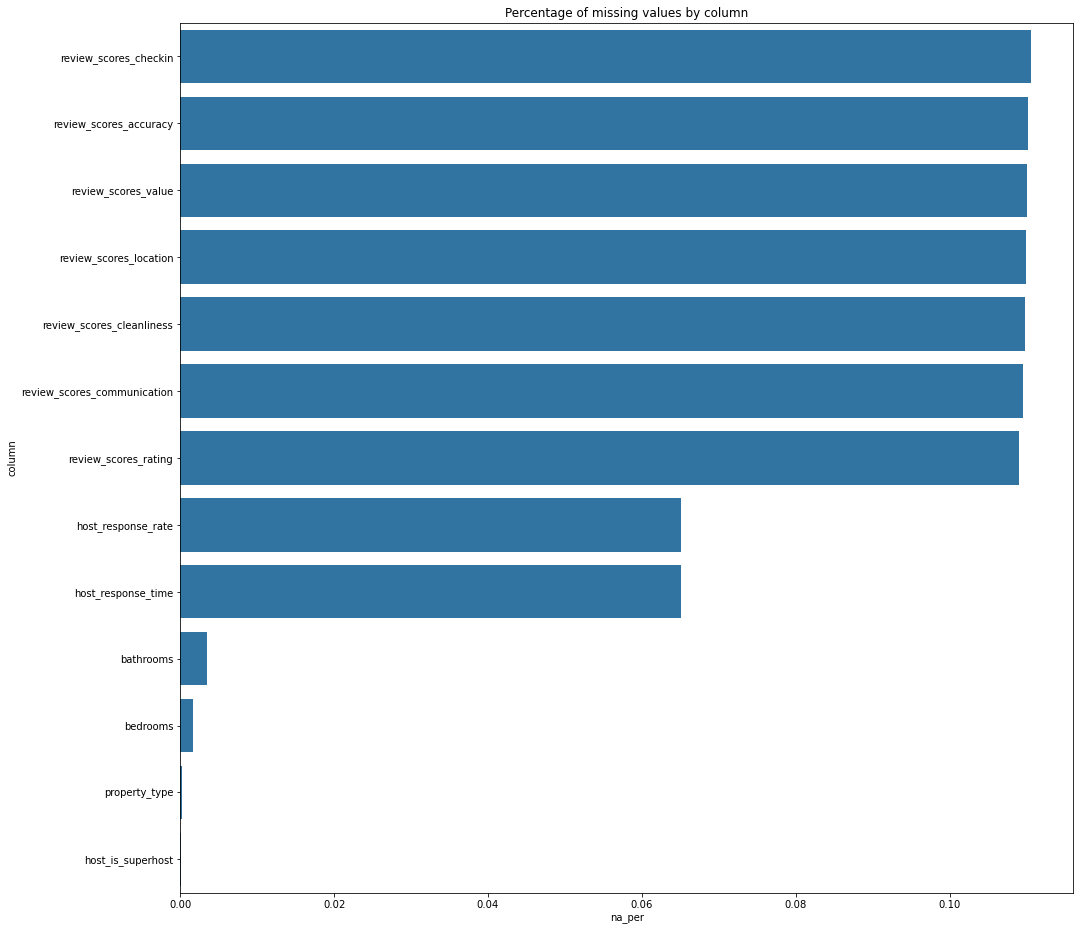

In [134]:
display_nans(df,0)

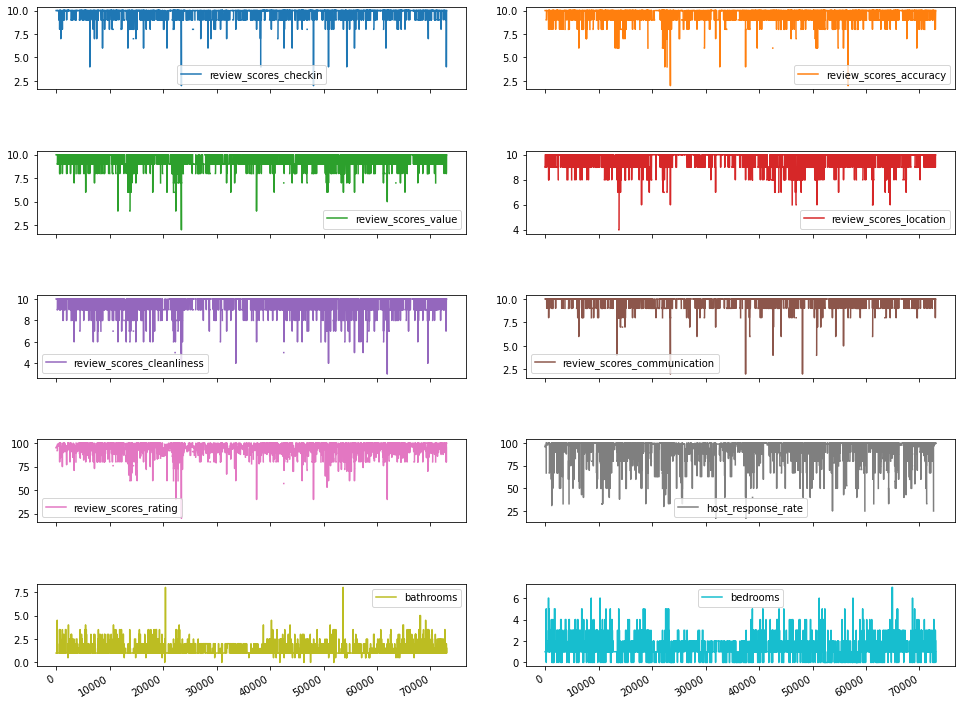

In [135]:
df[df_nan["column"]].plot(subplots=True, layout=(7,2),figsize=(14, 14))
plt.tight_layout(pad=3.0)
plt.savefig('Nan distributions')


For the remaining columns, we need to decide how to impute these results. By plotting their value distributions we can see that for most of these attributes the values are not well distributed within their range and have a couple of outlier values. In this case, we'll impute with the mode.

## Merged Data Visualiazions

Let's inspect the pricing trend by month and neighbourhood

In [136]:
#find average price per month
average_price_by_month = df.groupby(['month',"neighbourhood_group_cleansed"],as_index=False)['price'].mean()
average_price_by_month.head()

,month,neighbourhood_group_cleansed,price
0,1,Ballard,109.130
1,1,Beacon Hill,97.107
2,1,Capitol Hill,117.410
3,1,Cascade,128.908
4,1,Central Area,116.794


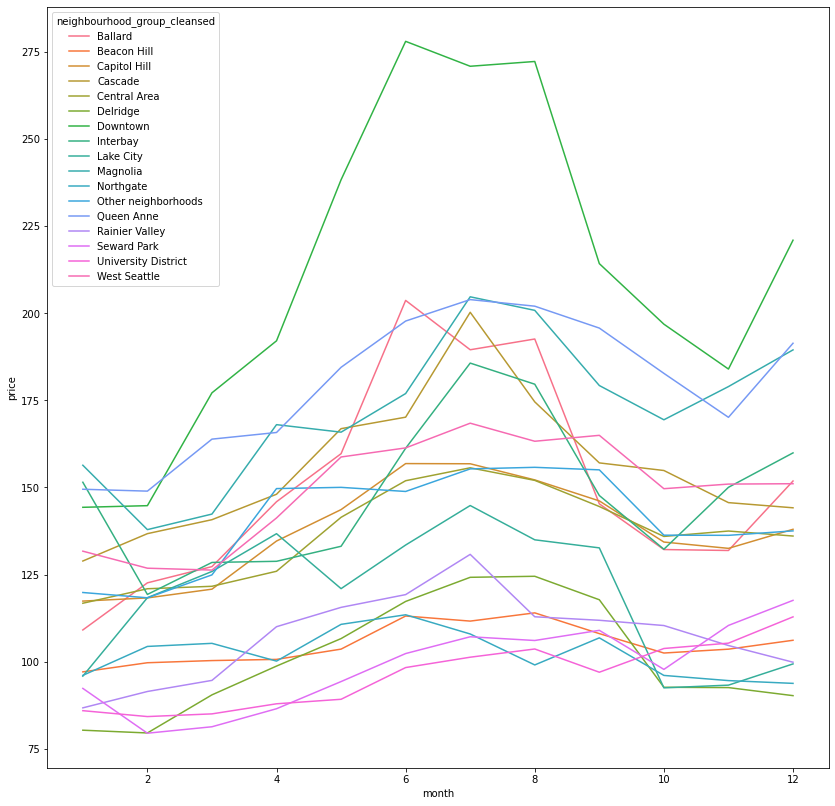

In [137]:
plt.figure(figsize=(14, 14))

sns.lineplot(data=average_price_by_month,
             x="month",
             y="price",
             err_style="bars",
             hue="neighbourhood_group_cleansed",
             )
plt.savefig('Seasonality of Pricing by Month and neighbourhood.png')

Let's inspect the pricing trend by month and number of bedrooms

In [138]:
#find average price per bedroom
average_price_by_month = df.groupby(["bedrooms"],as_index=False)['price'].mean()
average_price_by_month.head()

,bedrooms,price
0,0.000,121.772
1,1.000,111.096
2,2.000,212.180
3,3.000,279.288
4,4.000,303.784


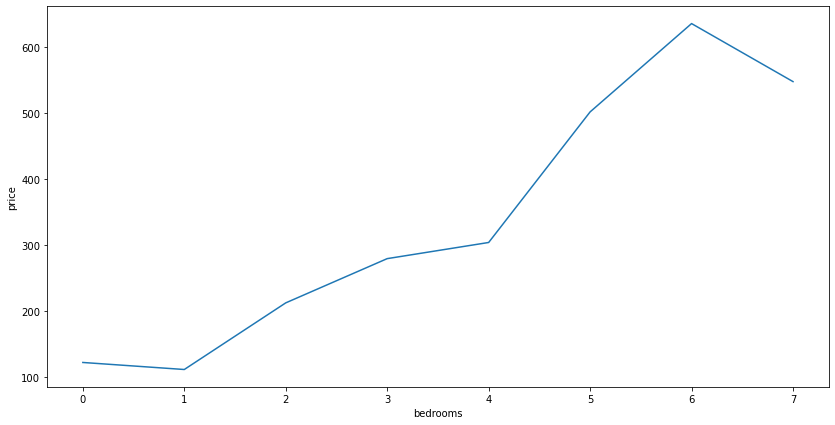

In [139]:
plt.figure(figsize=(14, 7))

sns.lineplot(data=average_price_by_month,
             x="bedrooms",
             y="price",
             err_style="bars"
            )
plt.savefig('Pricing by Month and bedroom.png')

## One Hot Encoding

This dataset contains many object dtypes fields and concatenated string feilds that represent categoprical data such as "amenities" are stripped and OneHotEncoded.

In [140]:
def split_cols(df,concat_cols,chars):
    '''
    input:
        Dataframe
        List of columns that you wish to clean and get dummies for
        list of characters you wish to remove
    output:
        1 - ",' characters are removed
        2 - charcters in chars string are removed
        3 - Original column is dropped and dummie columns are concatenated with prefix of columns name seperated by ","
    
    '''
    for col in concat_cols:
        df[col] = df[col].str.replace('"', "")
        df[col] = df[col].str.replace("'", "")
        for c in chars:
            df[col] = df[col].str.replace(c, "")
        df=pd.concat([df.drop(col, axis=1), df[col].str.get_dummies(sep=",").add_prefix(col+'_').astype(np.int8)], axis=1)
    return df    

chars = " [{}]"

concat_cols=["amenities"]
df=split_cols(df,concat_cols,chars)


In [141]:
def cat_onehot(df,method="median"):
    
    '''
    Input: Dataframe, imputation method (median or mode)
    Output: a dataframe where objects are converted to binary columns with dummie_na and remaining values are imputed with selected method
    '''
    global cat_df
    cat_df = df.select_dtypes(include=['object'])
    cat_cols = cat_df.columns

    df_cat=df.copy()

    for col in  cat_cols:
        df_cat = pd.concat([df_cat.drop(col, axis=1), pd.get_dummies(df_cat[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=True).astype(np.int8)], axis=1)

    if method=="median":
        # median function
        fill_med = lambda col: col.fillna(col.median())
        # Fill the median
        df_cat = df_cat.apply(fill_med, axis=0)

    if method=="mode":
        # mode function
        fill_mode = lambda col: col.fillna(col.mode()[0])
        # Fill the median
        df_cat = df_cat.apply(fill_mode, axis=0)

    return df_cat

df=cat_onehot(df,method="mode")

In [142]:
df.head()

,listing_id,host_response_rate,accommodates,bathrooms,bedrooms,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,month,amenities_24-HourCheck-in,amenities_AirConditioning,amenities_Breakfast,amenities_Buzzer/WirelessIntercom,amenities_CableTV,amenities_CarbonMonoxideDetector,amenities_Cat(s),amenities_Dog(s),amenities_Doorman,amenities_Dryer,amenities_ElevatorinBuilding,amenities_Essentials,amenities_Family/KidFriendly,amenities_FireExtinguisher,amenities_FirstAidKit,amenities_FreeParkingonPremises,amenities_Gym,amenities_HairDryer,amenities_Hangers,amenities_Heating,amenities_HotTub,amenities_IndoorFireplace,amenities_Internet,amenities_Iron,amenities_Kitchen,amenities_LaptopFriendlyWorkspace,amenities_LockonBedroomDoor,amenities_Otherpet(s),amenities_PetsAllowed,amenities_Petsliveonthisproperty,amenities_Pool,amenities_SafetyCard,amenities_Shampoo,amenities_SmokeDetector,amenities_SmokingAllowed,amenities_SuitableforEvents,amenities_TV,amenities_Washer,amenities_Washer/Dryer,amenities_WheelchairAccessible,amenities_WirelessInternet,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan,host_is_superhost_t,host_is_superhost_nan,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,neighbourhood_group_cleansed_nan,property_type_Bed & Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,property_type_nan,room_type_Private room,room_type_Shared room,room_type_nan,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_nan,require_guest_profile_picture_t,require_guest_profile_picture_nan,require_guest_phone_verification_t,require_guest_phone_verification_nan
0,241032,96.000,4,1.000,1.000,0,0,0,0,1,0.948,207,95.000,10.000,10.000,10.000,10.000,9.000,10.000,85.000,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
1,241032,96.000,4,1.000,1.000,0,0,0,0,1,0.948,207,95.000,10.000,10.000,10.000,10.000,9.000,10.000,85.000,2,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
2,241032,96.000,4,1.000,1.000,0,0,0,0,1,0.948,207,95.000,10.000,10.000,10.000,10.000,9.000,10.000,85.000,3,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
3,241032,96.000,4,1.000,1.000,0,0,0,0,1,0.948,207,95.000,10.000,10.000,10.000,10.000,9.000,10.000,85.000,4,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [143]:
df.shape

(73025, 116)

In [144]:
#check that all the columns are a numeric dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73025 entries, 0 to 73024
Columns: 116 entries, listing_id to require_guest_phone_verification_nan
dtypes: float64(12), int64(9), int8(95)
memory usage: 18.9 MB


## Modelling and Testing

### Linear Regression - train/test

In [145]:
#Split into explanatory and response variables
drops=["price","listing_id"]
X = df.drop(drops,axis=1)
y = df["price"]    

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

#print("test score:",test_score," train score:",train_score)

print('Linear Regression MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('Linear Regression R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

Linear Regression MSE train: 4110.818, test: 3984.061
Linear Regression R^2 train: 0.636, test: 0.637


This is already pretty good. The test and train datasets are yielding similar results and are not hinting at overfitting and approx 63% of the pricing is explained

### RandomForestRegressor - max_depth=4 - train/test

In [146]:
#prepare train and test datasets for modelling
drops=["price","listing_id"]
X = df.drop(drops,axis=1)
y = df["price"]    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

#train RF regressor model
forest = RandomForestRegressor(n_estimators=50, 
                               criterion='mse', 
                               random_state=42, 
                               n_jobs=-1,verbose=0,
                              max_depth=4)
forest.fit(X_train, y_train.squeeze())


#calculate scores for the model
y_train_preds = forest.predict(X_train)
y_test_preds = forest.predict(X_test)

print("Random Forest MSE train: %.3f, test: %.3f" % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print("Random Forest R^2 train: %.3f, test: %.3f" % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

Random Forest MSE train: 4396.454, test: 4263.072
Random Forest R^2 train: 0.611, test: 0.611


In [147]:
#https://mljar.com/blog/visualize-tree-from-random-forest/        r2_score(y_test, y_test_preds)))

# Extract single tree
estimator = forest.estimators_[5]

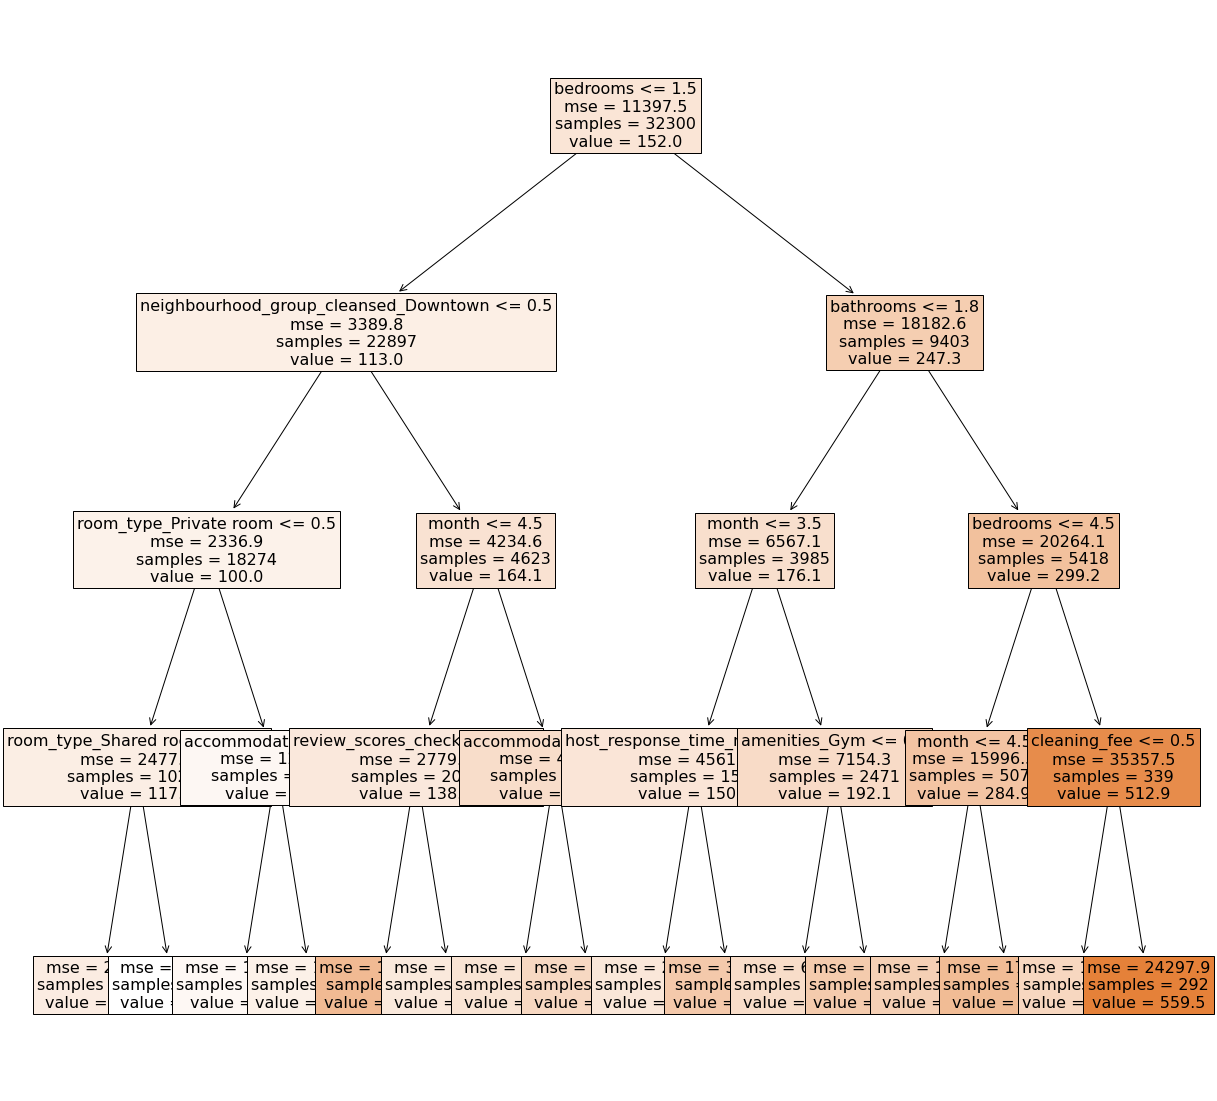

In [148]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(estimator, feature_names=X.columns, filled=True,precision=1,fontsize=16)
plt.savefig('RFR Tree.png')

Similar performance, but here we start to gain an insight into the characteristics that determine price

Let's see if we can do better

### RandomForestRegressor - train/test

In [149]:
#prepare train and test datasets for modelling
drops=["price","listing_id"]
X = df.drop(drops,axis=1)
y = df["price"]    


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

#train RF regressor model
forest = RandomForestRegressor(n_estimators=50, 
                               criterion='mse', 
                               random_state=42, 
                               n_jobs=-1,
                               verbose=0)
forest.fit(X_train, y_train.squeeze())


#calculate scores for the model
y_train_preds = forest.predict(X_train)
y_test_preds = forest.predict(X_test)

print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

Random Forest MSE train: 587.634, test: 1086.305
Random Forest R^2 train: 0.948, test: 0.901


Running the same model with no limitation on the maximum decision tree depth yields the below
As we are starting to see a differential between the training and test datasets we might be facing some degree of overfitting, but based on how small the difference is this model should fit this POC

### RandomForestRegressor - Final

In [150]:
#prepare train and test datasets for modelling
drops=["price","listing_id"]
X = df.drop(drops,axis=1)
y = df["price"]    

#train RF regressor model
forest = RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=42, 
                               n_jobs=-1,
                               verbose=0)
forest.fit(X, y)


#calculate scores for the model
y_pred = forest.predict(X)

print('Random Forest MSE: %.3f' % (mean_squared_error(y, y_pred)))
print('Random Forest R^2: %.3f' % (r2_score(y, y_pred)))

Random Forest MSE: 619.179
Random Forest R^2: 0.945


## Important Features

In [169]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X.columns, forest.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = headers)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

features = forest_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = forest_feature_importances['score'][:15]

features_scores=pd.DataFrame(values,columns =['features', 'score'])
features_scores=features_scores.set_index('features')
pd.options.display.float_format = '{:,.3f}'.format

print(features_scores.head(15))

                                         score
features                                      
bedrooms                                 0.387
bathrooms                                0.111
month                                    0.082
accommodates                             0.062
neighbourhood_group_cleansed_Downtown    0.036
room_type_Private room                   0.035
availability_365                         0.029
number_of_reviews                        0.021
cleaning_fee                             0.015
room_type_Shared room                    0.014
host_response_rate                       0.012
review_scores_rating                     0.012
neighbourhood_group_cleansed_Queen Anne  0.010
amenities_Gym                            0.009
review_scores_location                   0.008


In [154]:
features_scores_amen=features_scores[features_scores.index.str.contains("amen")]#

print(features_scores_amen.head())

                              score
features                           
amenities_Gym                 0.009
amenities_CableTV             0.005
amenities_AirConditioning     0.005
amenities_ElevatorinBuilding  0.005
amenities_Pool                0.005


## Good Value Apartments

Now that we understand the data and have modelled it we can then pipe this back into our original calendar dataset and identify listings by day that are below some threshold values (here is the head of a dataframe filtered by more than 50%)


This shows listings that have been potentially listing for a price lower than one would expect. Further investigation would be needed to understand why and if some remediation actions are needed.

In [155]:
df['price_prediction'] = y_pred

In [156]:
df["perc_diff_%"]=(df["price_prediction"]-df["price"])/df["price_prediction"]*100

In [157]:
df.head()

,listing_id,host_response_rate,accommodates,bathrooms,bedrooms,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,month,amenities_24-HourCheck-in,amenities_AirConditioning,amenities_Breakfast,amenities_Buzzer/WirelessIntercom,amenities_CableTV,amenities_CarbonMonoxideDetector,amenities_Cat(s),amenities_Dog(s),amenities_Doorman,amenities_Dryer,amenities_ElevatorinBuilding,amenities_Essentials,amenities_Family/KidFriendly,amenities_FireExtinguisher,amenities_FirstAidKit,amenities_FreeParkingonPremises,amenities_Gym,amenities_HairDryer,amenities_Hangers,amenities_Heating,amenities_HotTub,amenities_IndoorFireplace,amenities_Internet,amenities_Iron,amenities_Kitchen,amenities_LaptopFriendlyWorkspace,amenities_LockonBedroomDoor,amenities_Otherpet(s),amenities_PetsAllowed,amenities_Petsliveonthisproperty,amenities_Pool,amenities_SafetyCard,amenities_Shampoo,amenities_SmokeDetector,amenities_SmokingAllowed,amenities_SuitableforEvents,amenities_TV,amenities_Washer,amenities_Washer/Dryer,amenities_WheelchairAccessible,amenities_WirelessInternet,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan,host_is_superhost_t,host_is_superhost_nan,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,neighbourhood_group_cleansed_nan,property_type_Bed & Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,property_type_nan,room_type_Private room,room_type_Shared room,room_type_nan,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_nan,require_guest_profile_picture_t,require_guest_profile_picture_nan,require_guest_phone_verification_t,require_guest_phone_verification_nan,price_prediction,perc_diff_%
0,241032,96.000,4,1.000,1.000,0,0,0,0,1,0.948,207,95.000,10.000,10.000,10.000,10.000,9.000,10.000,85.000,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,86.508,1.744
1,241032,96.000,4,1.000,1.000,0,0,0,0,1,0.948,207,95.000,10.000,10.000,10.000,10.000,9.000,10.000,85.000,2,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,86.706,1.968
2,241032,96.000,4,1.000,1.000,0,0,0,0,1,0.948,207,95.000,10.000,10.000,10.000,10.000,9.000,10.000,85.000,3,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,87.552,2.915
3,241032,96.000,4,1.000,1.000,0,0,0,0,1,0.948,207,95.000,10.000,10.000,10.000,10.000,9.000,10.000,85.000,4,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0

In [158]:
threshold=50

df_short=df[df["perc_diff_%"]>threshold]
df_short.head()

,listing_id,host_response_rate,accommodates,bathrooms,bedrooms,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,month,amenities_24-HourCheck-in,amenities_AirConditioning,amenities_Breakfast,amenities_Buzzer/WirelessIntercom,amenities_CableTV,amenities_CarbonMonoxideDetector,amenities_Cat(s),amenities_Dog(s),amenities_Doorman,amenities_Dryer,amenities_ElevatorinBuilding,amenities_Essentials,amenities_Family/KidFriendly,amenities_FireExtinguisher,amenities_FirstAidKit,amenities_FreeParkingonPremises,amenities_Gym,amenities_HairDryer,amenities_Hangers,amenities_Heating,amenities_HotTub,amenities_IndoorFireplace,amenities_Internet,amenities_Iron,amenities_Kitchen,amenities_LaptopFriendlyWorkspace,amenities_LockonBedroomDoor,amenities_Otherpet(s),amenities_PetsAllowed,amenities_Petsliveonthisproperty,amenities_Pool,amenities_SafetyCard,amenities_Shampoo,amenities_SmokeDetector,amenities_SmokingAllowed,amenities_SuitableforEvents,amenities_TV,amenities_Washer,amenities_Washer/Dryer,amenities_WheelchairAccessible,amenities_WirelessInternet,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan,host_is_superhost_t,host_is_superhost_nan,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,neighbourhood_group_cleansed_nan,property_type_Bed & Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,property_type_nan,room_type_Private room,room_type_Shared room,room_type_nan,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_nan,require_guest_profile_picture_t,require_guest_profile_picture_nan,require_guest_phone_verification_t,require_guest_phone_verification_nan,price_prediction,perc_diff_%
12,953595,98.000,4,1.000,1.000,1,1,1,1,1,0.797,43,96.000,10.000,10.000,10.000,10.000,10.000,10.000,125.000,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,328.607,61.961
307,2493658,98.000,4,1.000,1.000,1,1,1,1,1,0.888,32,97.000,10.000,10.000,10.000,10.000,10.000,9.000,125.000,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,311.083,59.818
1367,2715623,100.000,3,1.000,1.000,0,0,0,1,1,0.849,9,91.000,9.000,10.000,9.000,9.000,10.000,10.000,240.000,7,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,508.962,52.845
1368,2715623,100.000,3,1.000,1.000,0,0,0,1,1,0.849,9,91.000,9.000,10.000,9.000,9.000,10.000,10.000,225.000,7,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,

In [159]:
df_short=df[df["perc_diff_%"]>threshold]

df_calendar_outlier=df_calendar[(df_calendar["listing_id"].isin(df_short["listing_id"])) & (df_calendar["price"].isin(df_short["price"]))]

In [160]:
df_calendar_outlier.head(10)

,listing_id,available,price,month
365,953595,t,125.000,1
484,953595,t,175.000,5
511,953595,t,172.000,5
514,953595,t,172.000,6
547,953595,t,185.000,7
590,953595,t,185.000,8
604,953595,t,175.000,8
606,953595,t,185.000,9
612,953595,t,172.000,9
659,953595,t,125.000,10


In [161]:
df_join=df_short[["price_prediction","perc_diff_%","listing_id"]]
df3 = df_calendar_outlier.merge(df_join, on=["listing_id"], how='inner')
df3=df3.drop("available",axis=1)

In [162]:
print(df3.head())

   listing_id   price  month  price_prediction  perc_diff_%
0      953595 125.000      1           328.607       61.961
1      953595 175.000      5           328.607       61.961
2      953595 172.000      5           328.607       61.961
3      953595 172.000      6           328.607       61.961
4      953595 185.000      7           328.607       61.961


## Pricing Mistakes

By extending the threshold further we can identify extreme outliers which could be fed into the websites front end for when a leaser is specifying how much their listing should be advertised at. 

This would have caught below examples which are orders of magnitude lower than one would expect for this property.

In [163]:
threshold=80

df_short=df[df["perc_diff_%"]>threshold]

df_calendar_outlier=df_calendar[(df_calendar["listing_id"].isin(df_short["listing_id"])) & (df_calendar["price"].isin(df_short["price"]))]


df_calendar_outlier.head(10)

df_join=df_short[["price_prediction","perc_diff_%","listing_id"]]
df3 = df_calendar_outlier.merge(df_join, on=["listing_id"], how='inner')

print(df3.head())

   listing_id available  price  month  price_prediction  perc_diff_%
0     6316917         t 12.000      1           100.312       88.037
1     4711069         t 10.000     11           100.320       90.032
